In [1]:
!nvidia-smi

Wed May 12 08:12:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import files
files.upload() #upload kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
import time
time.sleep(5)
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d noulam/tomato
!unzip -q /content/tomato.zip

Saving kaggle.json to kaggle.json
kaggle.json
 99% 737M/743M [00:31<00:00, 15.0MB/s]
100% 743M/743M [00:31<00:00, 24.4MB/s]


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


29089792/29084464 [==============================] - 1s 0us/step
Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
1147/1147 [==============================] - 390s 307ms/step - loss: 3.4833 - accuracy: 0.6743 - val_loss: 1.7764 - val_accuracy: 0.8543
Epoch 2/25
1147/1147 [==============================] - 346s 302ms/step - loss: 1.7660 - accuracy: 0.8646 - val_loss: 1.9191 - val_accuracy: 0.8722
Epoch 3/25
1147/1147 [==============================] - 341s 297ms/step - loss: 1.5313 - accuracy: 0.8965 - val_loss: 1.4646 - val_accuracy: 0.9095
Epoch 4/25
1147/1147 [==============================] - 339s 296ms/step - loss: 1.3121 - accuracy: 0.9167 - val_loss: 1.4876 - val_accuracy: 0.9149
Epoch 5/25
1147/1147 [==============================] - 334s 291ms/step - loss: 1.3299 - accuracy: 0.9214 - val_loss: 1.2215 - val_accuracy: 0.9346
Epoch 6/25
1147/1147 [==============================] - 337s 294ms/step - loss: 1.3091 - accuracy: 0.9300 - val_loss: 1.9056 - val_accuracy: 0.9147
Epoch 7/25
1147/1147 [==============================] - 342s 298ms/step - loss: 1.1783 - accuracy: 0.9359 - val_

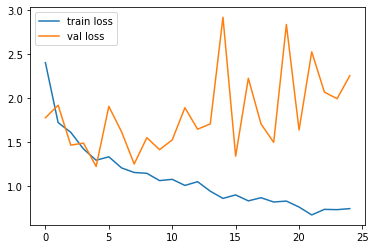

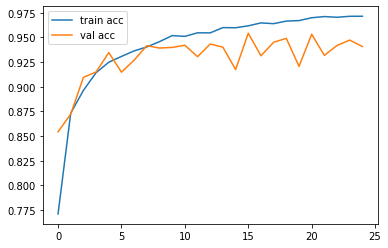

<Figure size 432x288 with 0 Axes>

In [4]:

import keras
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

# re-size all the images to this
IMAGE_SIZE = [224, 224]

# train_path = '/content/drive/My Drive/Eclipse/Train'
# valid_path = '/content/drive/My Drive/Eclipse/Test'

# add preprocessing layer to the front of VGG
vgg = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False


  
  # useful for getting number of classes
folders = glob('/content/New Plant Diseases Dataset(Augmented)/train/*')
  
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
# model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/New Plant Diseases Dataset(Augmented)/train',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory('/content/New Plant Diseases Dataset(Augmented)/valid',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical')

'''r=model.fit_generator(training_set,
                         samples_per_epoch = 8000,
                         nb_epoch = 5,
                         validation_data = test_set,
                         nb_val_samples = 2000)'''

# fit the model
r1 = model.fit_generator(
  training_set,
  validation_data=valid_set,
  epochs=25,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

# loss
plt.plot(r1.history['loss'], label='train loss')
plt.plot(r1.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(r1.history['accuracy'], label='train acc')
plt.plot(r1.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

import tensorflow as tf
from keras.models import load_model
model.save('/content/drive/MyDrive/Tomato_DenseNet121.h5')

# model.evaluate(pred, y_test, batch_size=16)